# An introduction to MetSim: Command line usage

Welcome to the first interactive component to our tutorial!
Now that we've got a handle on all things MetSim, let's actually _run_ it.
Predominantly, MetSim was designed to be a command line tool run through a shell interface.
Because we are in a Jupyter notebook we have to first discuss some technology related things to get set up.

Jupyter can run multiple _kernels_ which are the core programming languages or environments.
In fact, Jupyter actually stands for [**Ju**lia](https://julialang.org/), [**Pyt**hon](https://www.python.org/), and [**R**](https://www.r-project.org/).
Beyond this there are many community maintained kernels for almost any imaginable programming language.
This includes some shells, such as [bash](https://www.gnu.org/software/bash/).
However, we will not be taking the route of installing a bash kernel, but will instead rely on _cell magic_.

Cell magics are invoked with the `%` character. 
Some examples include `time`, `load`, and `who`. 
We can also use `%%bash` to invoke bash, rather than python, in a cell.
Using the cell magic to invoke bash will allow us to switch cleanly bewtween bash and python.
We will use bash to examine the inputs, as well as run MetSim itself.
Then, we will use python do do some simple processing and visualization of the output.
Following that, we will run MetSim from python itself and do some more advanced output processing.

Let's try using the `%%bash` magick real quick.

In [20]:
%%bash
for i in `seq 3`; do
    echo "hello ${i}!"
done

hello 1!
hello 2!
hello 3!


With this in mind, let's talk about how we do things with MetSim via the command line. 
As you already know from the background, MetSim uses a configuration file to specify input data and various options.
Let's start by looking at it.
We have named it `test.conf`, and it's sitting right here in the same directory as this notebook.
In bash, you can view the contents of a file by invoking a program called `cat`.
So, to view the contents of the configuration, do this:

In [21]:
%%bash
cat test.conf
echo ""

# This is an example of an input file for MetSim
[MetSim]
#out_vars = ['temp', 'prec', 'shortwave', 'longwave', 'vapor_pressure', 'rel_humid', 'air_pressure', 'wind']

# Time step in minutes
time_step = 180

# Forcings begin here (year/month/day:hour) (hour optional)
start = 1950/1/1

# Forcings end at this date (year/month/day)
stop = 1950/1/31

# Input and output directories
forcing = ./input/cli_test.nc
domain  = ./input/cli_domain.nc
state =   ./input/cli_state.nc

forcing_fmt = netcdf

out_dir = ./output
output_prefix = test

prec_type = triangle

[chunks]
lat = 3
lon = 1

[forcing_vars]
prec  = Prec
t_max = Tmax
t_min = Tmin
wind  = wind

[state_vars]
prec  = prec
t_max = t_max
t_min = t_min

[domain_vars]
lat  = lat
lon  = lon
mask = mask
elev = elev
t_pk = t_pk
dur  = dur



## Great! 
As you can see, the configuration file is relatively short, and mostly consists of setting variables.
Notice however, that there are several sections delineated by `[section_name]` headers.
This sort of file format is known as INI, and is relatively common for simple configurations.
Also note that comments in the configuration file begin with `#` just like python.
Let's dig into each of these sections separately.

### `[MetSim]`
This is the base header, which ensures that the config file is, in fact, for MetSim.
It controls general top level variables of interest.
Let's walk through them. We will examine just the variable names, and leave the values to description only if necessary.

* `out_vars` - this list contains all of the variables which we wish to write to the output data. For a list of the available options see [this page of the documentation](https://metsim.readthedocs.io/en/develop/data.html#output-specifications)
* `time_step` - this is the time step of the output (in minutes). There are some limiataions on what this is allowed to be. Of course, it can't be greater than 1440 (number of minutes in a day). But it also must be less than 360 (or 6 hours) for numerical reasons. We also should note that, while you can go down to output on the minute, it really doesn't make sense to set this lower than 30.
* `start` - The start date of the simulation, given as `YYYY/MM/DD`
* `stop` - The stop date of the simulation, given as `YYYY/MM/DD`
* `forcing` - The path to the forcing file(s). Multiple files can be given.
* `domain` - The path to the domain file
* `state` - The path to the state file
* `out_dir` - The location to write the output to. This must exist before running.
* `output_prefix` - The prefix that the output file(s) will get.
* `forcing_fmt` - The format of the input forcings. This can be `netcdf`, `binary`, or `ascii`. We will discuss each of these later.

### `[chunks]`
This section specifies how the domain will be broken up spatially. 
The variable names in this section are not fixed.
In this case we see
```
lat = 3
lon = 1
```
specifies that our domain is on a latitude longitude grid, and each 1 by 9 chunk of the domain will be run as a separate job.
Later in the tutorial we will see a configuration which will be 
```
hru = 3
```
whose domain is on an unstructured mesh.

### `[*_vars]` sections
These sections allow you to specify the mapping between variable names that the input datasets have to the ones that MetSim expects.
The format here is `metsim_varname = data_varname`, generally. 
The only exception to that rule will be explored later, such as when `forcing_fmt = binary`.

--- 

# Moving on

With the configuration in mind, let's look at how we run MetSim from the command line.
Because we are running using the cell magic we will have to activate our conda environment every time we wish to interact with MetSim.
Installing MetSim will add the `ms` command to your path.
Let's see it

In [22]:
%%bash
source activate pysum
which ms

/Users/amedin/anaconda/envs/pysum/bin/ms


# Let's talk options

Normally you could just run `ms --help` to view the options.
But, because we are running through the notebook interface we can't do this. 
Instead here's what you would see if you ran `ms --help`:

```
usage: ms [-h] [-n NUM_WORKERS] [-s SCHEDULER] [-v] config

positional arguments:
  config                Input configuration file

optional arguments:
  -h, --help            show this help message and exit
  -n NUM_WORKERS, --num_workers NUM_WORKERS
                        Parallel mode: number of processes to use
  -s SCHEDULER, --scheduler SCHEDULER
                        Dask scheduler to use
  -v, --verbose         Increase the verbosity of MetSim
```

Alright, so we can just run with `ms config`. Let's do it.

# Time to run
Now, we can just run MetSim by invoking the `ms` command with options as shown above.

In [23]:
%%bash
source activate pysum
ms test.conf -v -n 2

closed dask cluster/client


# We did it!
Alright, so despite some warnings we were able to complete our run!
Now, let's look at our output.
We can open the output as an xarray dataset, and do some plotting.

In [24]:
%pylab inline
import xarray as xr
output = xr.open_dataset('./output/forcing_19500101-19500131.nc')
output

Populating the interactive namespace from numpy and matplotlib


<xarray.Dataset>
Dimensions:         (lat: 3, lon: 3, time: 248)
Coordinates:
  * time            (time) datetime64[ns] 1950-01-01 ... 1950-01-31T21:00:00
  * lat             (lat) float64 30.03 30.09 30.16
  * lon             (lon) float64 -100.0 -99.97 -99.91
Data variables:
    temp            (time, lat, lon) float32 ...
    prec            (time, lat, lon) float32 ...
    shortwave       (time, lat, lon) float32 ...
    longwave        (time, lat, lon) float32 ...
    vapor_pressure  (time, lat, lon) float32 ...
    rel_humid       (time, lat, lon) float32 ...
Attributes:
    conventions:              1.6
    title:                    Output from MetSim
    institution:              University of Washington
    source:                   metsim.py
    history:                  Created: Mon Feb 24 22:48:07 2020 by amedin
    references:               Thornton, P.E., and S.W. Running, 1999. An impr...
    comment:                  no comment at this time
    period_ending:            False
    method:                   mtclim
    domain:                   ./input/cli_domain.nc
    state:                    ./input/cli_state.nc
    out_dir:                  /Users/amedin/Research/HydroSumma/MetSim-tutori...
    out_prefix:               forcing
    start:                    1950-01-01 00:00:00
    stop:                     1950-01-31 00:00:00
    time_step:                180
    calendar:                 standard
    prec_type:                triangle
    out_precision:            f4
    verbose:                  10
    sw_prec_thresh:           0.0
    utc_offset:               False
    lw_cloud:                 cloud_deardorff
    lw_type:                  prata
    tdew_tol:                 1e-06
    tmax_daylength_fraction:  0.67
    rain_scalar:              0.75
    tday_coef:                0.45
    lapse_rate:               0.0065
    out_vars:                 temp, prec, shortwave, longwave, vapor_pressure...
    chunks:                   {lat: 3, lon: 1}
    scheduler:                distributed
    num_workers:              2
    forcing:                  ./input/cli_test.nc
    forcing_fmt:              netcdf
    output_prefix:            test
    forcing_vars:             {Prec: prec, Tmax: t_max, Tmin: t_min, wind: wind}
    domain_vars:              {lat: lat, lon: lon, mask: mask, elev: elev, t_...
    state_vars:               {prec: prec, t_max: t_max, t_min: t_min}

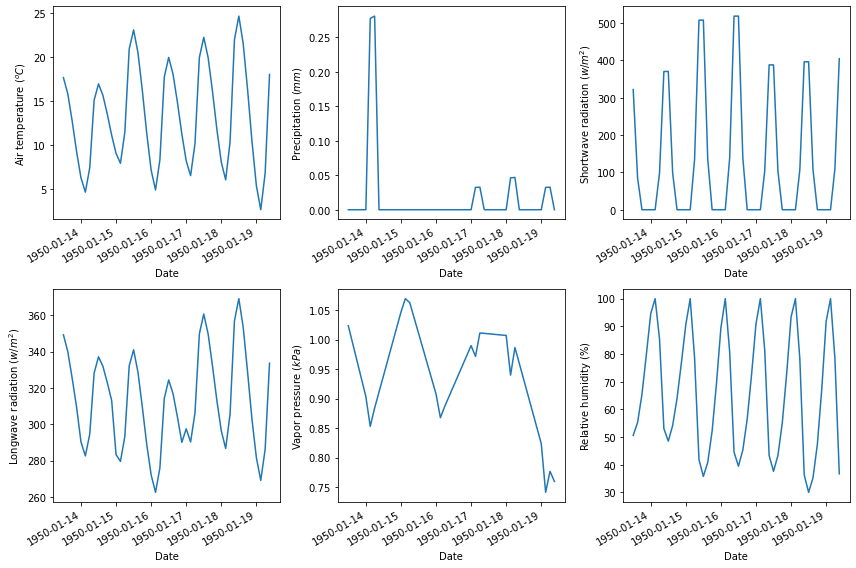

In [25]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()
unit_str = ['($ ^o C$)', '($mm$)', '($w/m^2$)','($w/m^2$)', '($kPa$)', '($\%$)',]


variables = list(output.variables.keys())
dims = list(output.dims.keys())
[variables.remove(d) for d in dims]

start = 100
stop = 148
for idx, var in enumerate(variables):
    output[var].isel(lat=1, lon=1, time=slice(start, stop)).plot(ax=axes[idx])
    axes[idx].set_title('') 
    axes[idx].set_ylabel('{} {}'.format(output[var].long_name.capitalize(), unit_str[idx]))
    axes[idx].set_xlabel('Date')
plt.tight_layout()